In [53]:
# Specify inputs:
days_data=20000 # Total number of days used for training
ticker='LINK-USD' # Examples: 'BTC-USD', 'ETH-USD', '^GSPC',...
lookback = 21 # Number of days used as lookback sequence
lookahead = 14 # Number of days used as lookahead sequence
price_change_threshold = 0.03  # k: 3% threshold for classification
# Hyper-parameter-optimization parameter:
n_layers_range = [1, 4] # Range of number of layers
units_1_range = [16, 128] # Range of first layer number of units
units_2_range = [8, 64] # Range of second layer number of units
units_3_range = [4, 32] # Range of third layer number of units
units_4_range = [2, 8] # Range of fourth layer number of units
dropout_rate_range = [0.1, 0.5] # Range of dropout value
learning_rate_range = [1e-5, 1e-2] # Range of learning rate
batch_size_choice = [16, 32, 64, 128] # Range of batch size

In [54]:
# Check if can use GPU:
import torch
print(torch.cuda.is_available())  # Should return True if GPU is available
import tensorflow as tf
tf.config.list_physical_devices('GPU')

False


[]

In [55]:
# Install/import required packages:
import subprocess
import sys

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])

try:
    import yfinance
    import ta
    import tensorflow as tf
    import optuna
    import pandas as pd
except ImportError:
    install_package('yfinance')
    install_package('ta')
    install_package('tensorflow')
    install_package('optuna')
    install_package('pandas')

import yfinance as yf
import ta
import tensorflow as tf
import optuna
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import clone_model
from tensorflow.keras.callbacks import Callback
import random

In [56]:
# Download data from Yahoo Finance:
print("=== LSTM Prediction with Technical Indicators ===")
print("\n1. Downloading  data...")
end_date = datetime.today()
start_date = end_date - timedelta(days=days_data)
df = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), 
                 end=end_date.strftime('%Y-%m-%d'), interval='1d')
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df = df.dropna()

# Ensure 'Open', 'High', 'Low', 'Close', 'Volume' are 1D:
series = pd.DataFrame()
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    df[col] = df[col].astype(float)
    values = df[col].values
    if values.ndim > 1:
        values = values.flatten()
    df[col] = values
    series[col] = pd.Series(values, index=df.index)

print(f"Downloaded {len(df)} days of data")
print("Columns:", df.columns.tolist())
print(df.head())

=== LSTM Prediction with Technical Indicators ===

1. Downloading  data...


/var/folders/qg/nq3l1x8n63q__7mhmf1lthlh0000gn/T/ipykernel_99816/4207558291.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'),
[*********************100%***********************]  1 of 1 completed

Downloaded 2831 days of data
Columns: [('Open', 'LINK-USD'), ('High', 'LINK-USD'), ('Low', 'LINK-USD'), ('Close', 'LINK-USD'), ('Volume', 'LINK-USD')]
Price           Open      High       Low     Close     Volume
Ticker      LINK-USD  LINK-USD  LINK-USD  LINK-USD   LINK-USD
Date                                                         
2017-11-09  0.216713  0.248233  0.195411  0.223969  3347920.0
2017-11-10  0.224700  0.231280  0.180161  0.187602  2125460.0
2017-11-11  0.186398  0.197687  0.166026  0.179770  2238980.0
2017-11-12  0.179667  0.198376  0.145948  0.170898  5455200.0
2017-11-13  0.169117  0.205014  0.168743  0.183071  2992650.0


In [57]:
# Add Technical Indicators:
print("\n2. Adding technical indicators...")

# Momentums:
df['RSI_14'] = ta.momentum.RSIIndicator(close=series['Close'], window=14).rsi()
df['ROC'] = ta.momentum.ROCIndicator(close=series['Close'], window=10).roc()
df['Stoch_K'] = ta.momentum.StochasticOscillator(high=series['High'], low=series['Low'], close=series['Close']).stoch()
df['Stoch_D'] = ta.momentum.StochasticOscillator(high=series['High'], low=series['Low'], close=series['Close']).stoch_signal()
df['Williams_R'] = ta.momentum.WilliamsRIndicator(high=series['High'], low=series['Low'], close=series['Close']).williams_r()

# EMAs:
df['EMA_20'] = ta.trend.EMAIndicator(close=series['Close'], window=20).ema_indicator()
df['EMA_50'] = ta.trend.EMAIndicator(close=series['Close'], window=50).ema_indicator()
df['EMA_200'] = ta.trend.EMAIndicator(close=series['Close'], window=200).ema_indicator()

# SMAs:
df['SMA_20'] = ta.trend.SMAIndicator(close=series['Close'], window=20).sma_indicator()
df['SMA_50'] = ta.trend.SMAIndicator(close=series['Close'], window=50).sma_indicator()
df['SMA_200'] = ta.trend.SMAIndicator(close=series['Close'], window=200).sma_indicator()

# Parabolic SAR:
df['PSAR'] = ta.trend.PSARIndicator(high=series['High'], low=series['Low'], close=series['Close']).psar()

# Average Directional Index (ADX):
adx = ta.trend.ADXIndicator(high=series['High'], low=series['Low'], close=series['Close'])
df['ADX'] = adx.adx()
df['DI_plus'] = adx.adx_pos()
df['DI_minus'] = adx.adx_neg()

# Ichimoku Cloud:
ichimoku = ta.trend.IchimokuIndicator(high=series['High'], low=series['Low'])
df['Ichimoku_A'] = ichimoku.ichimoku_a()
df['Ichimoku_B'] = ichimoku.ichimoku_b()
df['Ichimoku_base'] = ichimoku.ichimoku_base_line()
df['Ichimoku_conversion'] = ichimoku.ichimoku_conversion_line()

# Commodity Channel Index:
df['CCI'] = ta.trend.CCIIndicator(high=series['High'], low=series['Low'], close=series['Close']).cci()

# Bollinger Bands:
bb = ta.volatility.BollingerBands(close=series['Close'])
df['BB_upper'] = bb.bollinger_hband()
df['BB_lower'] = bb.bollinger_lband()
df['BB_middle'] = bb.bollinger_mavg()
df['BB_width'] = bb.bollinger_wband()
df['BB_percent'] = bb.bollinger_pband()

# Average True Range (ATR):
df['ATR'] = ta.volatility.AverageTrueRange(high=series['High'], low=series['Low'], close=series['Close']).average_true_range()

# Keltner Channel
kc = ta.volatility.KeltnerChannel(high=series['High'], low=series['Low'], close=series['Close'])
df['KC_upper'] = kc.keltner_channel_hband()
df['KC_lower'] = kc.keltner_channel_lband()
df['KC_middle'] = kc.keltner_channel_mband()

# Volumes:
df['MFI'] = ta.volume.MFIIndicator(high=series['High'], low=series['Low'], close=series['Close'], volume=series['Volume']).money_flow_index()
df['OBV'] = ta.volume.OnBalanceVolumeIndicator(close=series['Close'], volume=series['Volume']).on_balance_volume()
df['VWAP'] = ta.volume.VolumeWeightedAveragePrice(high=series['High'], low=series['Low'], close=series['Close'], volume=series['Volume']).volume_weighted_average_price()
df['ADL'] = ta.volume.AccDistIndexIndicator(high=series['High'], low=series['Low'], close=series['Close'], volume=series['Volume']).acc_dist_index()
df['CMF'] = ta.volume.ChaikinMoneyFlowIndicator(high=series['High'], low=series['Low'], close=series['Close'], volume=series['Volume']).chaikin_money_flow()

# True Range:
df['True_Range'] = np.maximum(
    series['High'] - series['Low'],
    np.maximum(
        np.abs(series['High'] - series['Close'].shift(1)),
        np.abs(series['Low'] - series['Close'].shift(1))
    )
)

# Detrended Price Oscillator:
df['DPO'] = ta.trend.DPOIndicator(close=series['Close']).dpo()

# Percentage Price Oscillator:
ppo = ta.momentum.PercentagePriceOscillator(close=series['Close'])
df['PPO'] = ppo.ppo()
df['PPO_signal'] = ppo.ppo_signal()
df['PPO_hist'] = ppo.ppo_hist()

# MACD:
macd = ta.trend.MACD(close=series['Close'])
df['MACD'] = macd.macd()
df['MACD_signal'] = macd.macd_signal()

df = df.dropna()
print(f"Added technical indicators. Final dataset shape: {df.shape}")
print("Final columns:", df.columns.tolist())
print(df.head())


2. Adding technical indicators...
Added technical indicators. Final dataset shape: (2632, 46)
Final columns: [('Open', 'LINK-USD'), ('High', 'LINK-USD'), ('Low', 'LINK-USD'), ('Close', 'LINK-USD'), ('Volume', 'LINK-USD'), ('RSI_14', ''), ('ROC', ''), ('Stoch_K', ''), ('Stoch_D', ''), ('Williams_R', ''), ('EMA_20', ''), ('EMA_50', ''), ('EMA_200', ''), ('SMA_20', ''), ('SMA_50', ''), ('SMA_200', ''), ('PSAR', ''), ('ADX', ''), ('DI_plus', ''), ('DI_minus', ''), ('Ichimoku_A', ''), ('Ichimoku_B', ''), ('Ichimoku_base', ''), ('Ichimoku_conversion', ''), ('CCI', ''), ('BB_upper', ''), ('BB_lower', ''), ('BB_middle', ''), ('BB_width', ''), ('BB_percent', ''), ('ATR', ''), ('KC_upper', ''), ('KC_lower', ''), ('KC_middle', ''), ('MFI', ''), ('OBV', ''), ('VWAP', ''), ('ADL', ''), ('CMF', ''), ('True_Range', ''), ('DPO', ''), ('PPO', ''), ('PPO_signal', ''), ('PPO_hist', ''), ('MACD', ''), ('MACD_signal', '')]
Price           Open      High       Low     Close     Volume     RSI_14  \
Ticker 

['Open', 'High', 'Low', 'Close', 'Volume', 'RSI_14', 'ROC', 'Stoch_K', 'Stoch_D', 'Williams_R', 'EMA_20', 'EMA_50', 'EMA_200', 'SMA_20', 'SMA_50', 'SMA_200', 'PSAR', 'ADX', 'DI_plus', 'DI_minus', 'Ichimoku_A', 'Ichimoku_B', 'Ichimoku_base', 'Ichimoku_conversion', 'CCI', 'BB_upper', 'BB_lower', 'BB_middle', 'BB_width', 'BB_percent', 'ATR', 'KC_upper', 'KC_lower', 'KC_middle', 'MFI', 'OBV', 'VWAP', 'ADL', 'CMF', 'True_Range', 'DPO', 'PPO', 'PPO_signal', 'PPO_hist', 'MACD', 'MACD_signal']
<class 'list'>


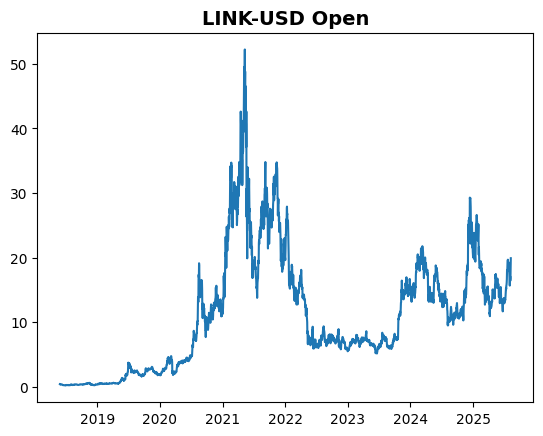

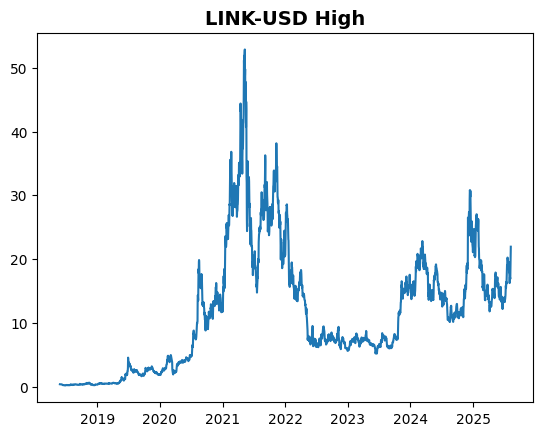

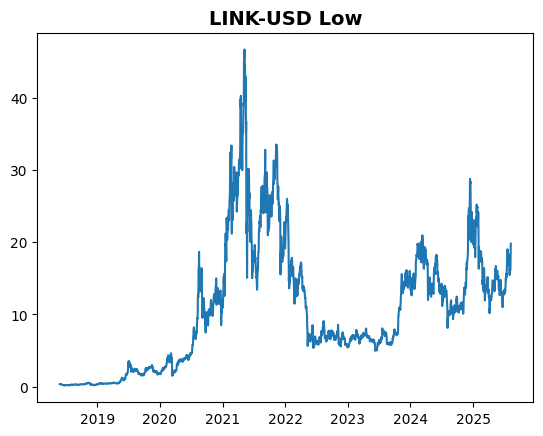

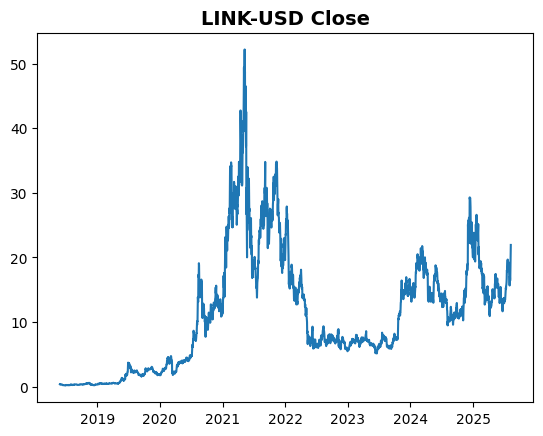

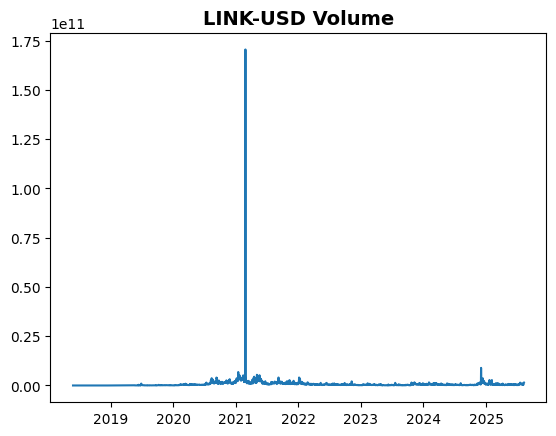

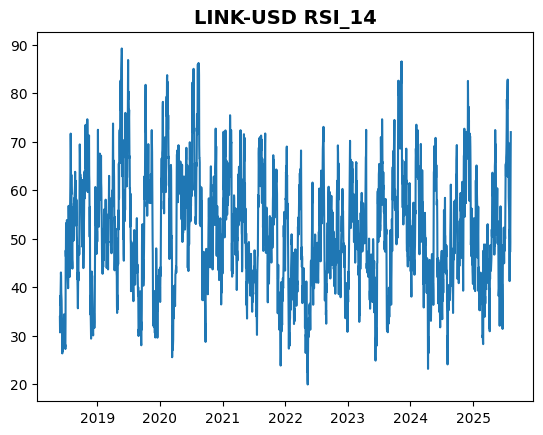

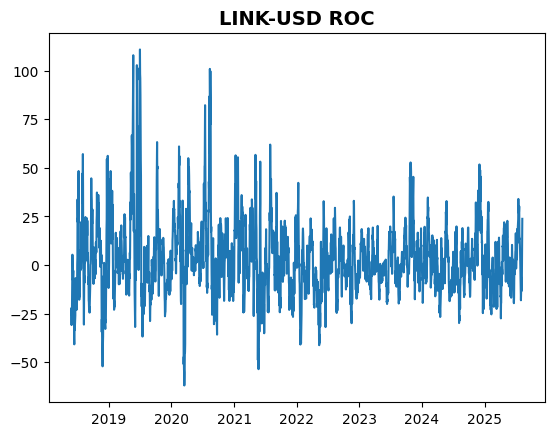

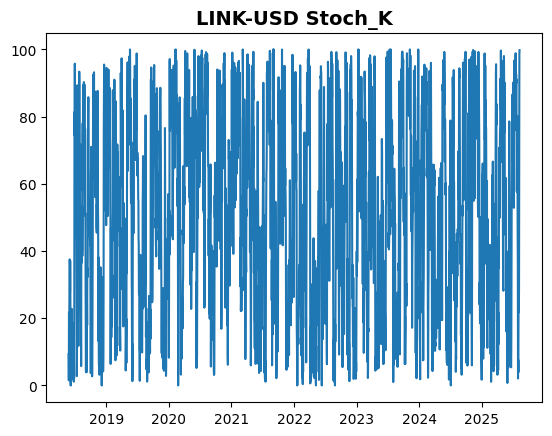

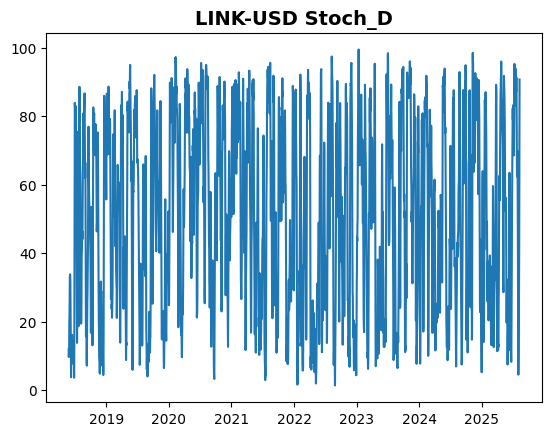

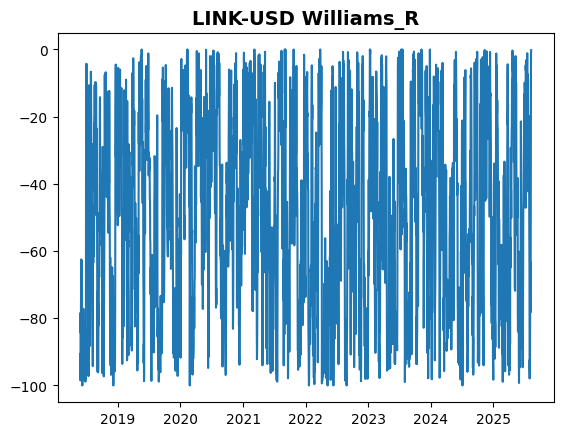

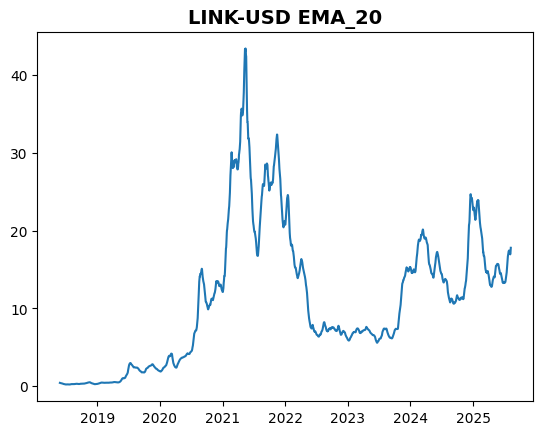

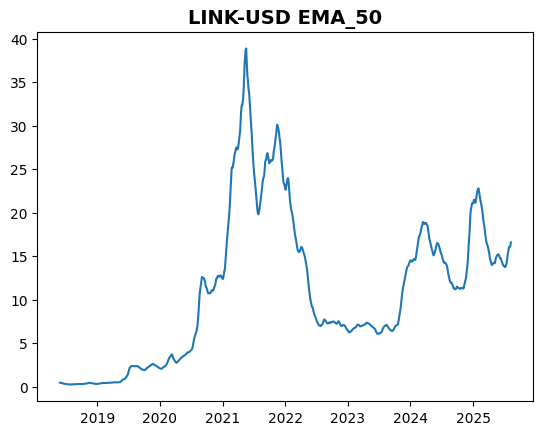

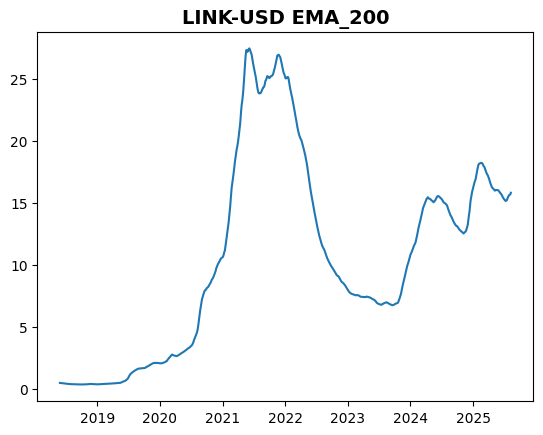

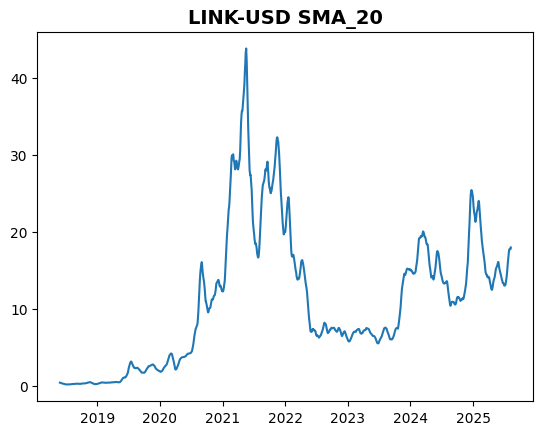

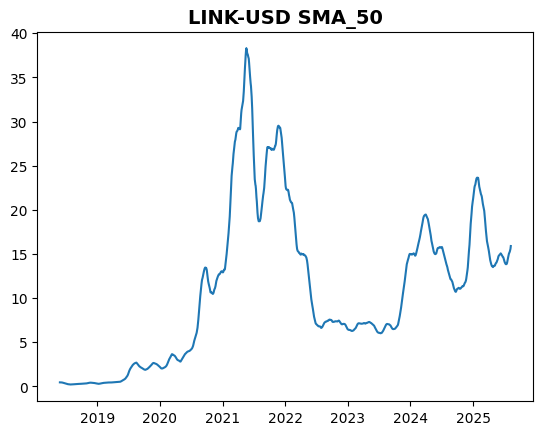

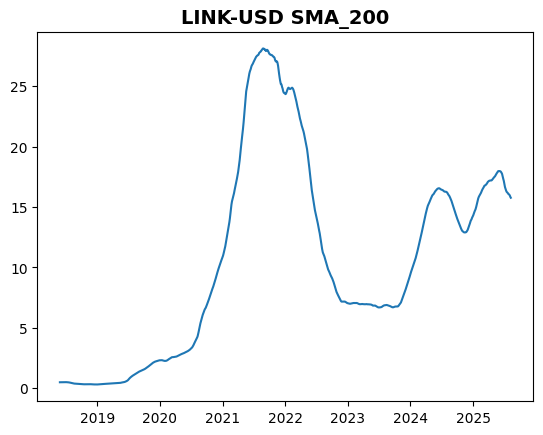

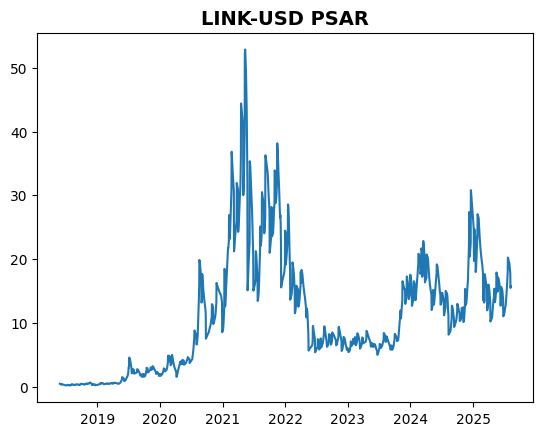

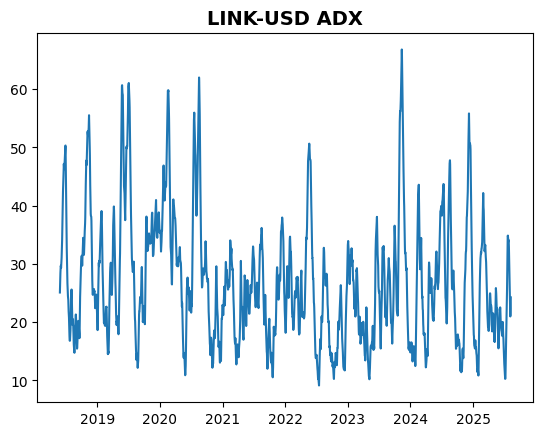

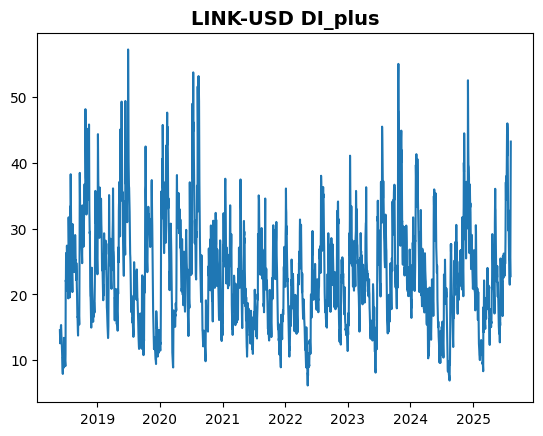

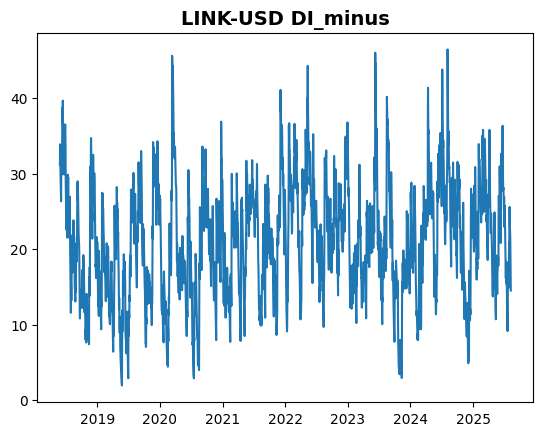

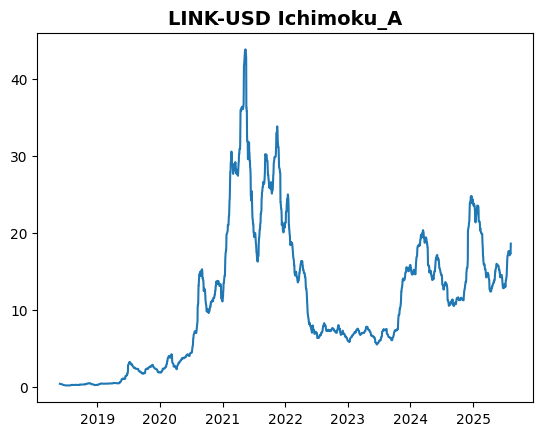

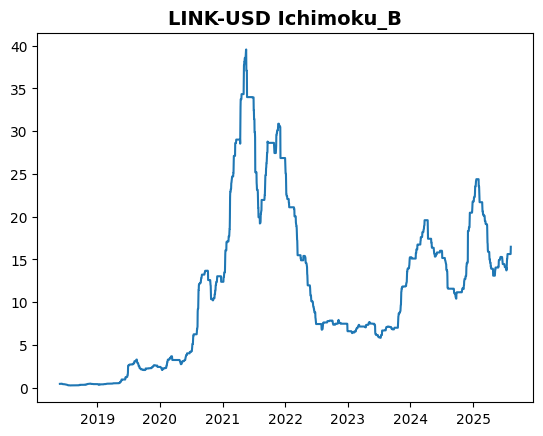

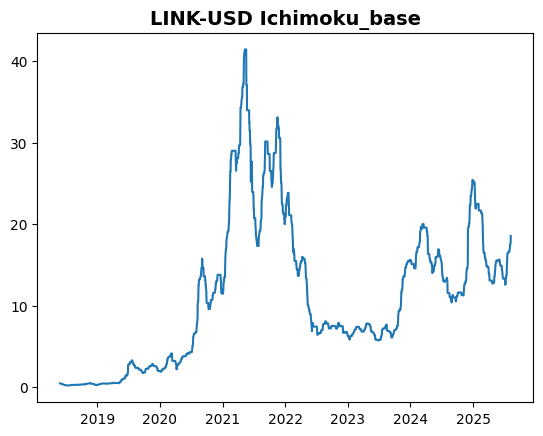

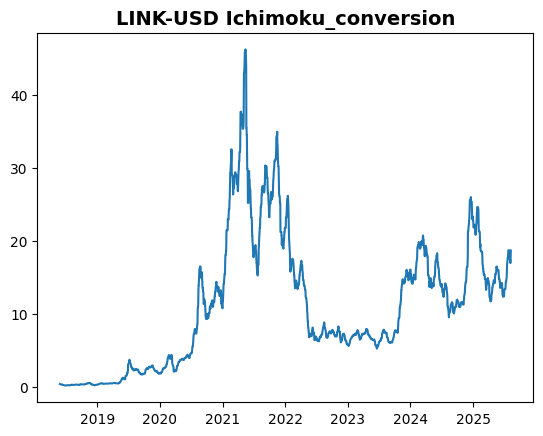

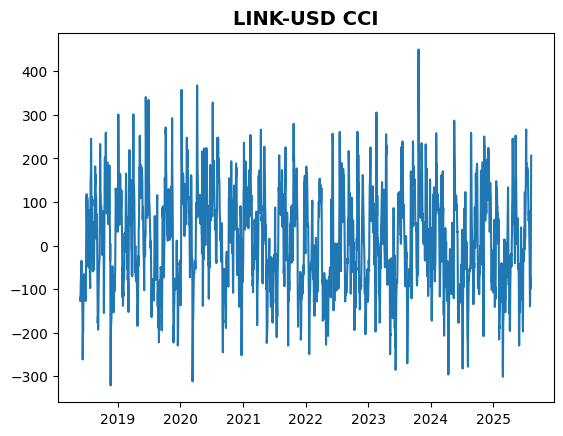

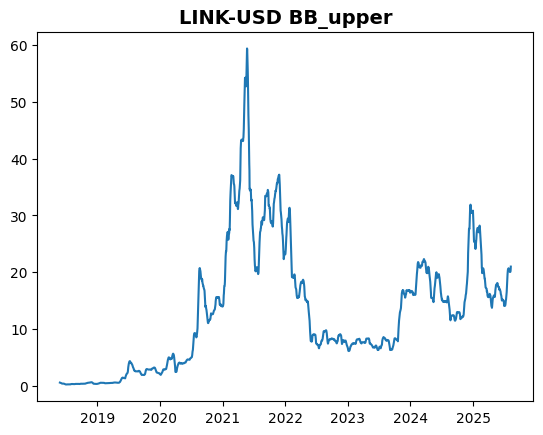

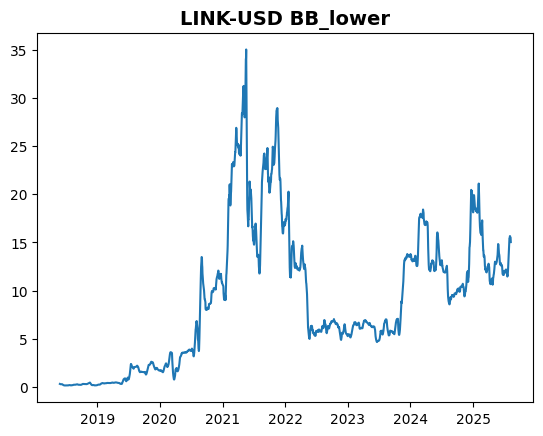

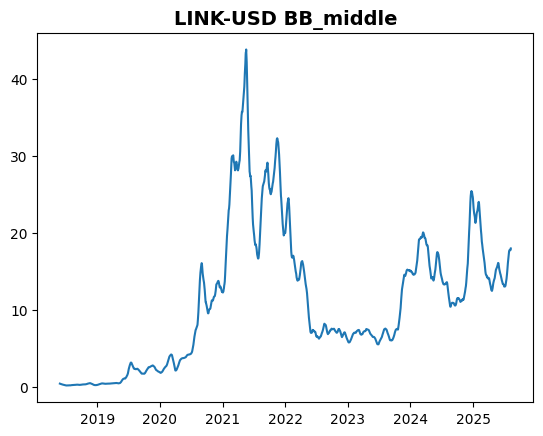

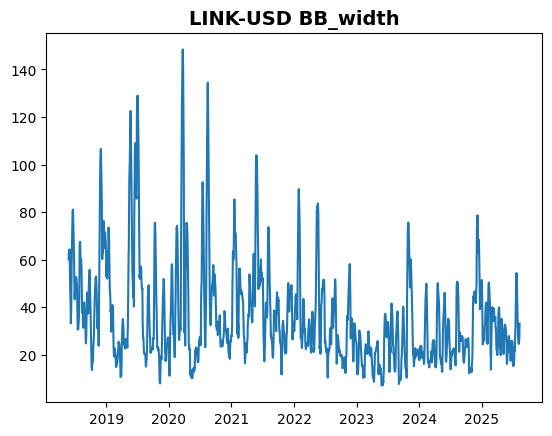

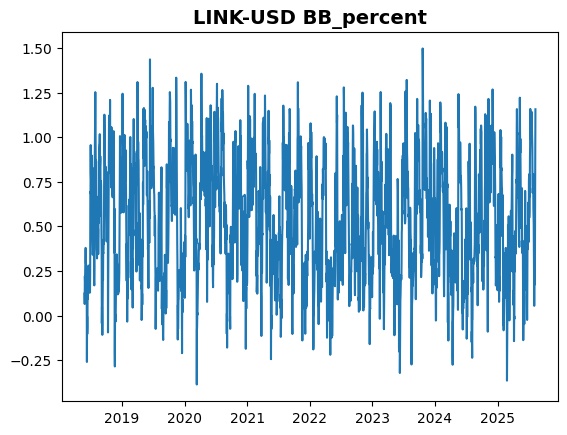

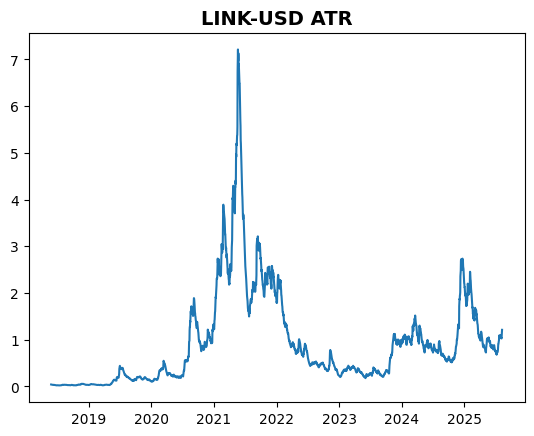

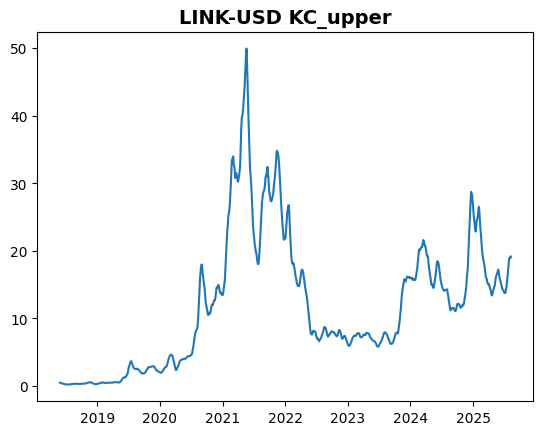

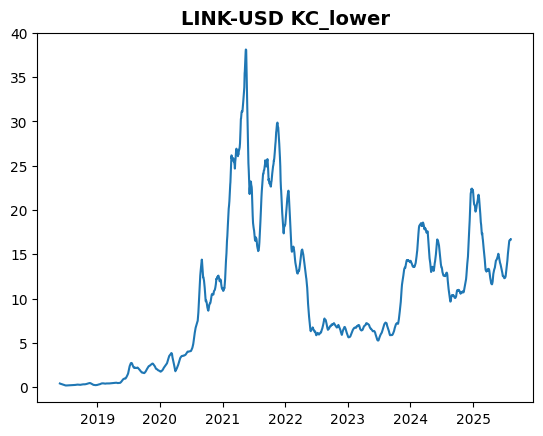

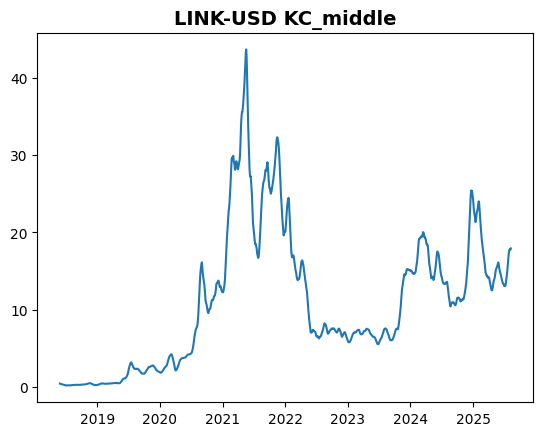

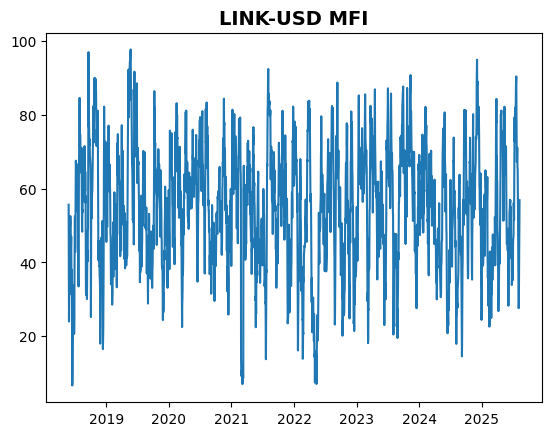

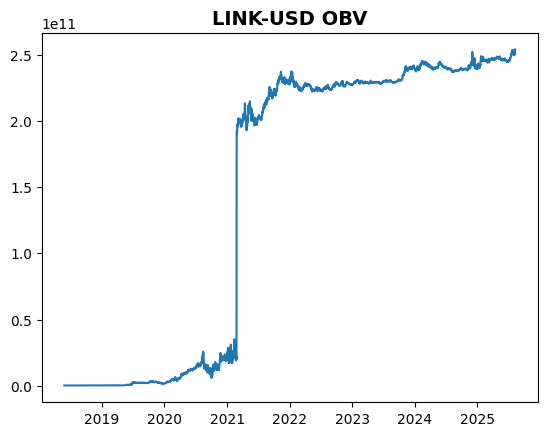

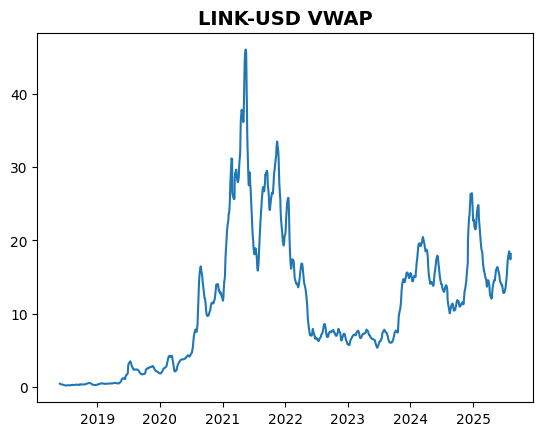

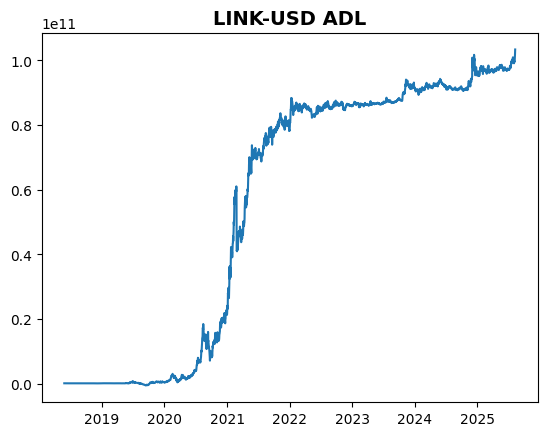

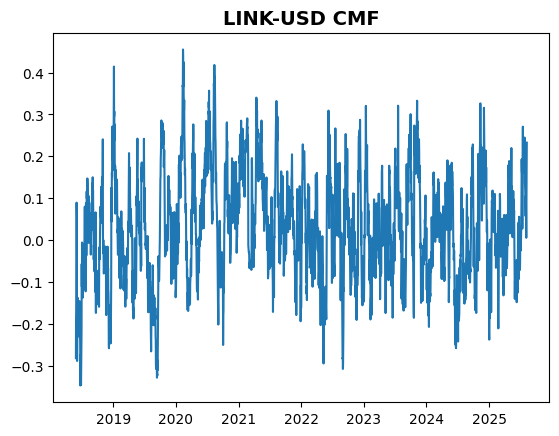

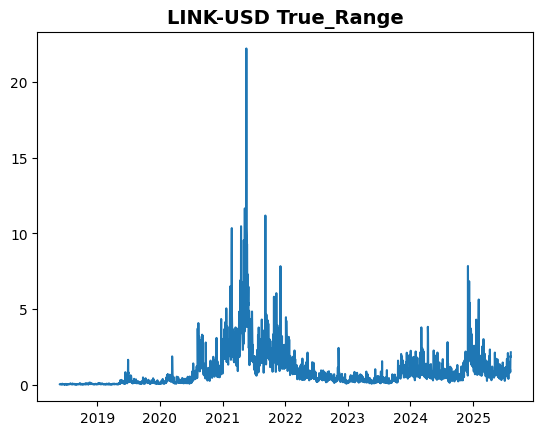

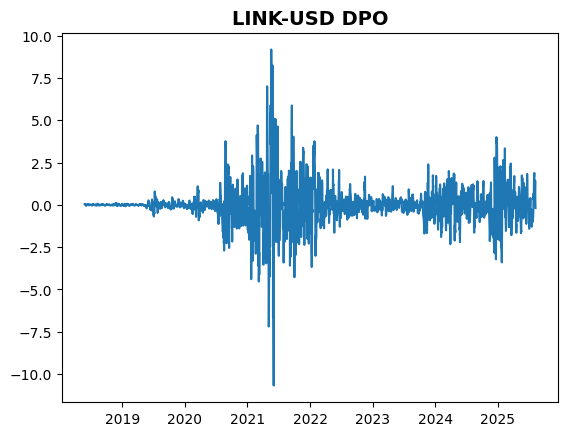

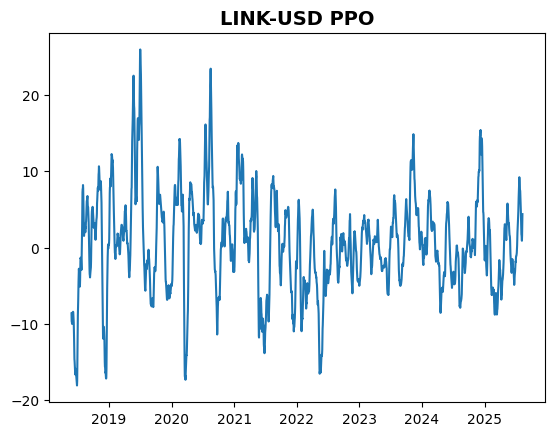

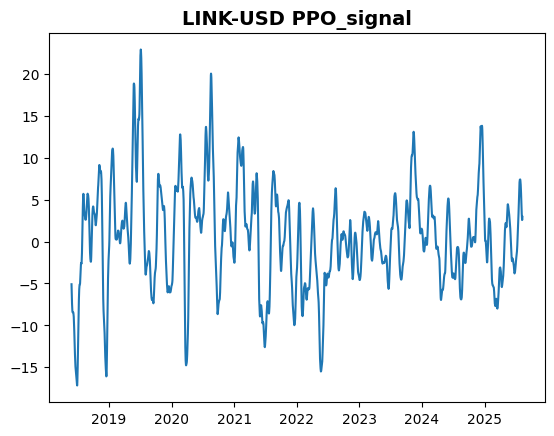

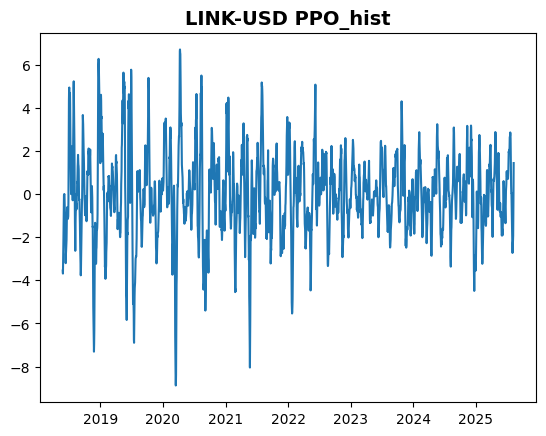

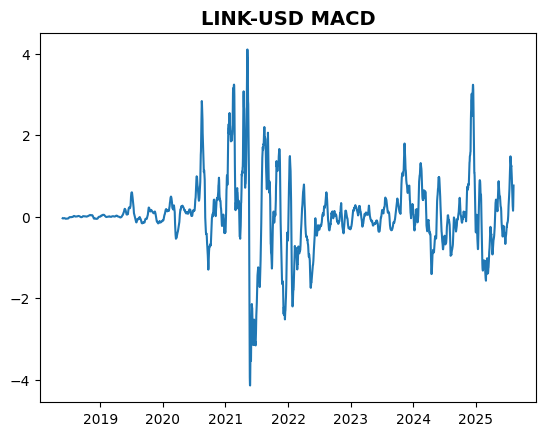

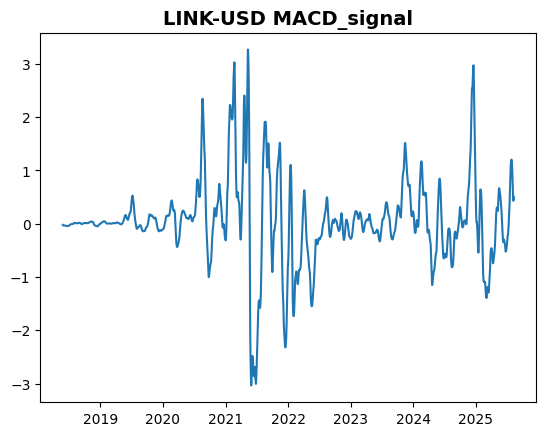

In [58]:
# Plot all features and labels:
features = [x for x, y in df.columns.tolist()]
print(features)
print(type(features))
for col in features:
    plt.figure()
    plt.plot(df[col])
    plt.title(ticker+' '+col, fontsize=14, fontweight='bold')
    plt.show()

In [59]:
import numpy as np

def generate_labels(close_prices, method='avg', lookahead=10, threshold=0.01,
                    open_prices=None, high_prices=None, low_prices=None, percentile_low=30, percentile_high=70):
    """
    Generate buy/sell/hold labels using different strategies.

    Parameters:
        close_prices (np.array): Close prices
        method (str): 'avg', 'max', 'median', etc
        lookahead (int): Future window to evaluate signal
        threshold (float): % threshold or risk-adjusted threshold
        open_prices, high_prices, low_prices (np.array): Needed for 'candle'

    Returns:
        labels (np.array): -1 = sell, 0 = hold, 1 = buy
    """
    n = len(close_prices)
    labels = np.zeros(n)

    for i in range(n - lookahead):
        current_price = close_prices[i]
        future_slice = close_prices[i+1:i+1+lookahead]

        if method == 'avg':
            future_metric = np.mean(future_slice)
            pct_change = (future_metric - current_price) / current_price

        elif method == 'max':
            future_metric = np.max(future_slice)
            pct_change = (future_metric - current_price) / current_price

        elif method == 'median':
            future_metric = np.median(future_slice)
            pct_change = (future_metric - current_price) / current_price

        # For avg, max, median:
        if pct_change > threshold:
            labels[i] = 1
        elif pct_change < -threshold:
            labels[i] = -1
        else:
            labels[i] = 0

    return labels

In [60]:
# === Switchable Label Generation ===
labels = generate_labels(
    close_prices=df['Close'].values,
    method='avg',  # try 'avg', 'max', 'median', etc.
    lookahead=lookahead,
    threshold=price_change_threshold,
    open_prices=df['Open'].values,
    high_prices=df['High'].values,
    low_prices=df['Low'].values,
    percentile_low=30,
    percentile_high=70
)

# === Prepare LSTM input sequences (X) and labels (y) ===
# Prepare Data for LSTM:
print("\n5. Preparing LSTM data...")
features = df.columns.tolist()
print("Available features:", features)
sorted_features=features
print("Top most important features being used:", sorted_features)

X, y = [], []
close_prices = df['Close'].values
feature_data = df[sorted_features].values
X = []
y = []
for i in range(lookback, len(df) - lookahead):  # ensure alignment with labels
    X.append(feature_data[i - lookback:i+1])  # this should already be defined in your earlier code
    y.append(labels[i])

X = np.array(X)

# One-hot encode labels
from tensorflow.keras.utils import to_categorical
label_mapping = {-1: 0, 0: 1, 1: 2}
y = to_categorical([label_mapping[l] for l in y], num_classes=3)
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
print(y[-20:])
# Analyze label distribution before one-hot encoding
raw_labels = y.argmax(axis=1)  # Convert one-hot back to integer labels

unique, counts = np.unique(raw_labels, return_counts=True)
total = len(raw_labels)

for label, count in zip(unique, counts):
    percent = (count / total) * 100
    print(f"Label {label} count: {count} ({percent:.2f}%)")


5. Preparing LSTM data...
Available features: [('Open', 'LINK-USD'), ('High', 'LINK-USD'), ('Low', 'LINK-USD'), ('Close', 'LINK-USD'), ('Volume', 'LINK-USD'), ('RSI_14', ''), ('ROC', ''), ('Stoch_K', ''), ('Stoch_D', ''), ('Williams_R', ''), ('EMA_20', ''), ('EMA_50', ''), ('EMA_200', ''), ('SMA_20', ''), ('SMA_50', ''), ('SMA_200', ''), ('PSAR', ''), ('ADX', ''), ('DI_plus', ''), ('DI_minus', ''), ('Ichimoku_A', ''), ('Ichimoku_B', ''), ('Ichimoku_base', ''), ('Ichimoku_conversion', ''), ('CCI', ''), ('BB_upper', ''), ('BB_lower', ''), ('BB_middle', ''), ('BB_width', ''), ('BB_percent', ''), ('ATR', ''), ('KC_upper', ''), ('KC_lower', ''), ('KC_middle', ''), ('MFI', ''), ('OBV', ''), ('VWAP', ''), ('ADL', ''), ('CMF', ''), ('True_Range', ''), ('DPO', ''), ('PPO', ''), ('PPO_signal', ''), ('PPO_hist', ''), ('MACD', ''), ('MACD_signal', '')]
Top most important features being used: [('Open', 'LINK-USD'), ('High', 'LINK-USD'), ('Low', 'LINK-USD'), ('Close', 'LINK-USD'), ('Volume', 'LINK-

In [61]:
# Build and Train LSTM Model for Classification:
print("\n6. Building and training LSTM classification model...")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale features:
n_features = X.shape[2]
scaler = StandardScaler()
X_train_reshaped = X_train.reshape(-1, n_features)
X_test_reshaped = X_test.reshape(-1, n_features)
X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

X_train_train, X_train_eval, y_train_train, y_train_eval = train_test_split(X_train_scaled, y_train, test_size=0.25, shuffle=False)
print(X_train_train.shape)
print(X_train_eval.shape)
print(X_test.shape)

y_train_true = y_train_train.argmax(axis=1)
y_eval_true = y_train_eval.argmax(axis=1)
y_test_true = y_test.argmax(axis=1)

# Compute class weights to handle imbalance:
from sklearn.utils import class_weight
import numpy as np

y_train_labels = y_train.argmax(axis=1)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# Define focal loss function:
import tensorflow.keras.backend as K

def focal_loss(gamma=2., alpha=None):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        if alpha is not None:
            alpha_tensor = K.constant(alpha, dtype=K.floatx())
            cross_entropy = alpha_tensor * cross_entropy
        loss = K.pow(1 - y_pred, gamma) * cross_entropy
        return K.mean(K.sum(loss, axis=-1))
    return focal_loss_fixed

# Hyperparameter optimization function:
best_model = None
best_history = None
best_params = None
best_signal_accuracy_so_far_train = 0.0
best_signal_accuracy_so_far_eval = 0.0
best_signal_accuracy_so_far_test = 0.0

from sklearn.metrics import precision_score, recall_score, f1_score

def signal_accuracy_metric(y_true, y_pred):
    signal_mask = y_pred != 1  # Only Buy or Sell
    if signal_mask.sum() == 0:
        return 0.0
    correct_signals = (y_true[signal_mask] == y_pred[signal_mask]).sum()
    return correct_signals / signal_mask.sum()

def objective(trial):
    global best_model, best_history, best_params, best_signal_accuracy_so_far_train, best_signal_accuracy_so_far_eval, best_signal_accuracy_so_far_test

    n_layers = trial.suggest_int('n_layers', n_layers_range[0], n_layers_range[1])
    units_1 = trial.suggest_int('units_1', units_1_range[0], units_1_range[1])
    units_2 = trial.suggest_int('units_2', units_2_range[0], units_2_range[1]) if n_layers >= 2 else 0
    units_3 = trial.suggest_int('units_3', units_3_range[0], units_3_range[1]) if n_layers >= 3 else 0
    units_4 = trial.suggest_int('units_4', units_4_range[0], units_4_range[1]) if n_layers >= 4 else 0

    dropout_rate = trial.suggest_float('dropout_rate', dropout_rate_range[0], dropout_rate_range[1])
    learning_rate = trial.suggest_float('learning_rate', learning_rate_range[0], learning_rate_range[1], log=True)
    batch_size = trial.suggest_categorical('batch_size', batch_size_choice)
    gamma_val = trial.suggest_float('gamma', 0.5, 5.0)

    model = Sequential()
    model.add(LSTM(units_1, return_sequences=(n_layers > 1), input_shape=(lookback + 1, X.shape[2])))
    model.add(Dropout(dropout_rate))
    if n_layers >= 2:
        model.add(LSTM(units_2, return_sequences=(n_layers > 2)))
        model.add(Dropout(dropout_rate))
    if n_layers >= 3:
        model.add(LSTM(units_3, return_sequences=(n_layers > 3)))
        model.add(Dropout(dropout_rate))
    if n_layers >= 4:
        model.add(LSTM(units_4))
        model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))

    # Step 1: Suggest 3 unbounded values
    w0 = trial.suggest_float("class_w0", 0.1, 5.0)
    w1 = trial.suggest_float("class_w1", 0.1, 5.0)
    w2 = trial.suggest_float("class_w2", 0.1, 5.0)

    # Step 2: Normalize weights
    weight_sum = w0 + w1 + w2
    alpha_list = [w0 / weight_sum, w1 / weight_sum, w2 / weight_sum]
    class_weight_dict = {0: alpha_list[0], 1: alpha_list[1], 2: alpha_list[2]}

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=focal_loss(gamma=gamma_val, alpha=alpha_list),
                  metrics=['accuracy'])

    class MetricsCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            y_train_pred = self.model.predict(X_train_train).argmax(axis=1)
            y_eval_pred = self.model.predict(X_train_eval).argmax(axis=1)
            y_test_pred = self.model.predict(X_test_scaled).argmax(axis=1)

            sig_acc_train = signal_accuracy_metric(y_train_true, y_train_pred)
            sig_acc_eval = signal_accuracy_metric(y_eval_true, y_eval_pred)
            sig_acc_test = signal_accuracy_metric(y_test_true, y_test_pred)

            trial.set_user_attr(f'epoch_{epoch + 1}_signal_accuracy_train', sig_acc_train)
            trial.set_user_attr(f'epoch_{epoch + 1}_signal_accuracy_eval', sig_acc_eval)
            trial.set_user_attr(f'epoch_{epoch + 1}_signal_accuracy_test', sig_acc_test)
            
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train_train, y_train_train,
        epochs=10,
        batch_size=batch_size,
        validation_data=(X_train_eval, y_train_eval),
        callbacks=[early_stopping, MetricsCallback()],
        class_weight=class_weights_dict,
        verbose=1
    )

    y_train_pred = model.predict(X_train_train).argmax(axis=1)
    y_eval_pred = model.predict(X_train_eval).argmax(axis=1)
    y_test_pred = model.predict(X_test_scaled).argmax(axis=1)

    sig_acc_train = signal_accuracy_metric(y_train_true, y_train_pred)
    sig_acc_eval = signal_accuracy_metric(y_eval_true, y_eval_pred)
    sig_acc_test = signal_accuracy_metric(y_test_true, y_test_pred)

    trial.set_user_attr("final_signal_accuracy_train", sig_acc_train)
    trial.set_user_attr("final_signal_accuracy_eval", sig_acc_eval)
    trial.set_user_attr("final_signal_accuracy_test", sig_acc_test)

    # Track best model
    current_best_value = min(history.history['val_loss'])
    if best_model is None or current_best_value < study.best_value:
        best_signal_accuracy_so_far_train = sig_acc_train
        best_signal_accuracy_so_far_eval = sig_acc_eval
        best_signal_accuracy_so_far_test = sig_acc_test
        best_model = model
        best_history = history
        best_params = trial.params

    return current_best_value

# Run hyperparameter optimization:
print("Running hyperparameter optimization...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)  # Increase n_trials for better results

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Use the best model found during optimization:
print("Using best model from optimization...")
model = best_model
history = best_history

print("Best model summary:")
model.summary()

[I 2025-08-11 00:50:25,618] A new study created in memory with name: no-name-54e3d191-a0f5-44a6-b742-22c750de07f2



6. Building and training LSTM classification model...
(1557, 22, 46)
(520, 22, 46)
(520, 22, 46)
Class Weights: {0: 0.9961630695443645, 1: 1.5249632892804699, 2: 0.7460488505747126}
Running hyperparameter optimization...
Epoch 1/10
98/98 [==============================] - 10s 38ms/step - loss: 0.2352 - accuracy: 0.4746 - val_loss: 0.2647 - val_accuracy: 0.3788
Epoch 2/10
98/98 [==============================] - 2s 20ms/step - loss: 0.2268 - accuracy: 0.4894 - val_loss: 0.2689 - val_accuracy: 0.3346
Epoch 3/10
98/98 [==============================] - 2s 18ms/step - loss: 0.2241 - accuracy: 0.5022 - val_loss: 0.2656 - val_accuracy: 0.3923
Epoch 4/10
98/98 [==============================] - 2s 21ms/step - loss: 0.2240 - accuracy: 0.4894 - val_loss: 0.2687 - val_accuracy: 0.3788
Epoch 5/10
98/98 [==============================] - 2s 21ms/step - loss: 0.2171 - accuracy: 0.5132 - val_loss: 0.2566 - val_accuracy: 0.3615
Epoch 6/10
98/98 [==============================] - 2s 22ms/step - loss:

[I 2025-08-11 00:50:55,154] Trial 0 finished with value: 0.2565723657608032 and parameters: {'n_layers': 2, 'units_1': 95, 'units_2': 57, 'dropout_rate': 0.18833917725114319, 'learning_rate': 0.009454985224764992, 'batch_size': 16, 'gamma': 0.8636409369129794, 'class_w0': 3.286366568740044, 'class_w1': 2.1696433490193177, 'class_w2': 4.245257086978126}. Best is trial 0 with value: 0.2565723657608032.


Epoch 1/10
49/49 [==============================] - 4s 28ms/step - loss: 0.1223 - accuracy: 0.3674 - val_loss: 0.1235 - val_accuracy: 0.3346
Epoch 2/10
49/49 [==============================] - 1s 14ms/step - loss: 0.1070 - accuracy: 0.3956 - val_loss: 0.1310 - val_accuracy: 0.2885
Epoch 3/10
49/49 [==============================] - 1s 14ms/step - loss: 0.1010 - accuracy: 0.4451 - val_loss: 0.1245 - val_accuracy: 0.3288
Epoch 4/10
49/49 [==============================] - 1s 17ms/step - loss: 0.0957 - accuracy: 0.4791 - val_loss: 0.1326 - val_accuracy: 0.3288
Epoch 5/10
49/49 [==============================] - 1s 12ms/step - loss: 0.0940 - accuracy: 0.5048 - val_loss: 0.1520 - val_accuracy: 0.3462
Epoch 6/10
49/49 [==============================] - 1s 13ms/step - loss: 0.0935 - accuracy: 0.5074 - val_loss: 0.1603 - val_accuracy: 0.2942
Epoch 7/10
49/49 [==============================] - 1s 12ms/step - loss: 0.0884 - accuracy: 0.5260 - val_loss: 0.1822 - val_accuracy: 0.2981
Epoch 8/10
49

[I 2025-08-11 00:51:05,754] Trial 1 finished with value: 0.12353096157312393 and parameters: {'n_layers': 1, 'units_1': 30, 'dropout_rate': 0.36855254617939137, 'learning_rate': 0.005292270238079247, 'batch_size': 32, 'gamma': 2.392998684857549, 'class_w0': 1.1320852798497545, 'class_w1': 4.647024694076796, 'class_w2': 2.1202326688166186}. Best is trial 1 with value: 0.12353096157312393.


Epoch 1/10
13/13 [==============================] - 11s 297ms/step - loss: 0.1024 - accuracy: 0.3738 - val_loss: 0.1113 - val_accuracy: 0.3173
Epoch 2/10
13/13 [==============================] - 2s 132ms/step - loss: 0.0848 - accuracy: 0.4412 - val_loss: 0.1026 - val_accuracy: 0.3423
Epoch 3/10
13/13 [==============================] - 2s 141ms/step - loss: 0.0756 - accuracy: 0.4573 - val_loss: 0.0966 - val_accuracy: 0.3654
Epoch 4/10
13/13 [==============================] - 1s 100ms/step - loss: 0.0701 - accuracy: 0.4566 - val_loss: 0.0911 - val_accuracy: 0.3846
Epoch 5/10
13/13 [==============================] - 1s 102ms/step - loss: 0.0656 - accuracy: 0.4611 - val_loss: 0.0866 - val_accuracy: 0.3827
Epoch 6/10
13/13 [==============================] - 1s 99ms/step - loss: 0.0643 - accuracy: 0.4605 - val_loss: 0.0828 - val_accuracy: 0.3846
Epoch 7/10
13/13 [==============================] - 1s 111ms/step - loss: 0.0616 - accuracy: 0.4650 - val_loss: 0.0792 - val_accuracy: 0.4038
Epoch 

[I 2025-08-11 00:51:31,916] Trial 2 finished with value: 0.07285107672214508 and parameters: {'n_layers': 3, 'units_1': 111, 'units_2': 39, 'units_3': 17, 'dropout_rate': 0.1806346809024734, 'learning_rate': 8.193990627170077e-05, 'batch_size': 128, 'gamma': 2.9487338168995385, 'class_w0': 0.3111055855121474, 'class_w1': 3.765661133510471, 'class_w2': 4.84828897672922}. Best is trial 2 with value: 0.07285107672214508.


Epoch 1/10
49/49 [==============================] - 10s 74ms/step - loss: 0.0755 - accuracy: 0.4412 - val_loss: 0.0822 - val_accuracy: 0.3519
Epoch 2/10
49/49 [==============================] - 2s 33ms/step - loss: 0.0556 - accuracy: 0.4868 - val_loss: 0.0645 - val_accuracy: 0.3596
Epoch 3/10
49/49 [==============================] - 2s 34ms/step - loss: 0.0503 - accuracy: 0.5042 - val_loss: 0.0598 - val_accuracy: 0.3423
Epoch 4/10
49/49 [==============================] - 2s 31ms/step - loss: 0.0462 - accuracy: 0.5132 - val_loss: 0.0567 - val_accuracy: 0.3462
Epoch 5/10
49/49 [==============================] - 2s 31ms/step - loss: 0.0434 - accuracy: 0.5209 - val_loss: 0.0560 - val_accuracy: 0.3404
Epoch 6/10
49/49 [==============================] - 1s 29ms/step - loss: 0.0425 - accuracy: 0.5376 - val_loss: 0.0557 - val_accuracy: 0.3288
Epoch 7/10
49/49 [==============================] - 1s 31ms/step - loss: 0.0415 - accuracy: 0.5453 - val_loss: 0.0564 - val_accuracy: 0.3288
Epoch 8/10
4

[I 2025-08-11 00:51:58,653] Trial 3 finished with value: 0.055726125836372375 and parameters: {'n_layers': 3, 'units_1': 73, 'units_2': 39, 'units_3': 5, 'dropout_rate': 0.20602472182317633, 'learning_rate': 0.00015902994256396398, 'batch_size': 32, 'gamma': 3.680537840665564, 'class_w0': 4.464078714513793, 'class_w1': 0.3121342219918938, 'class_w2': 4.861876782220169}. Best is trial 3 with value: 0.055726125836372375.


Epoch 1/10
49/49 [==============================] - 12s 95ms/step - loss: 0.0451 - accuracy: 0.4534 - val_loss: 0.0492 - val_accuracy: 0.3596
Epoch 2/10
49/49 [==============================] - 2s 47ms/step - loss: 0.0377 - accuracy: 0.4727 - val_loss: 0.0454 - val_accuracy: 0.3596
Epoch 3/10
49/49 [==============================] - 1s 29ms/step - loss: 0.0361 - accuracy: 0.4759 - val_loss: 0.0453 - val_accuracy: 0.3731
Epoch 4/10
49/49 [==============================] - 1s 30ms/step - loss: 0.0350 - accuracy: 0.4855 - val_loss: 0.0459 - val_accuracy: 0.3577
Epoch 5/10
49/49 [==============================] - 1s 27ms/step - loss: 0.0338 - accuracy: 0.5061 - val_loss: 0.0452 - val_accuracy: 0.3615
Epoch 6/10
49/49 [==============================] - 1s 25ms/step - loss: 0.0326 - accuracy: 0.5183 - val_loss: 0.0473 - val_accuracy: 0.3577
Epoch 7/10
49/49 [==============================] - 1s 22ms/step - loss: 0.0314 - accuracy: 0.5344 - val_loss: 0.0477 - val_accuracy: 0.3596
Epoch 8/10
4

[I 2025-08-11 00:52:23,788] Trial 4 finished with value: 0.045172397047281265 and parameters: {'n_layers': 2, 'units_1': 45, 'units_2': 59, 'dropout_rate': 0.22660091973292498, 'learning_rate': 0.0003047240160965762, 'batch_size': 32, 'gamma': 4.783005564651291, 'class_w0': 0.5951905997244472, 'class_w1': 1.5363322939341186, 'class_w2': 3.255768748801052}. Best is trial 4 with value: 0.045172397047281265.


Best trial:
  Value:  0.045172397047281265
  Params: 
    n_layers: 2
    units_1: 45
    units_2: 59
    dropout_rate: 0.22660091973292498
    learning_rate: 0.0003047240160965762
    batch_size: 32
    gamma: 4.783005564651291
    class_w0: 0.5951905997244472
    class_w1: 1.5363322939341186
    class_w2: 3.255768748801052
Using best model from optimization...
Best model summary:
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_55 (LSTM)              (None, 22, 45)            16560     
                                                                 
 dropout_55 (Dropout)        (None, 22, 45)            0         
                                                                 
 lstm_56 (LSTM)              (None, 59)                24780     
                                                                 
 dropout_56 (Dropout)        (None, 59)                0        

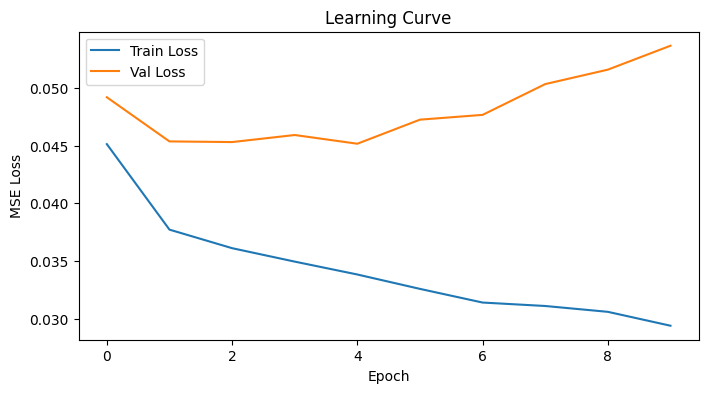

In [62]:
# Plot learning curves
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Learning Curve')
plt.show()

In [63]:
# Evaluate:
test_loss = model.evaluate(X_test_scaled, y_test)
print(test_loss)
print(X_test_scaled.shape)
print(y_test.shape)
print(f'Test MSE and accuracy: {test_loss}')

# Make predictions and visualize
print("\n6. Making predictions and creating visualizations...")
y_pred = model.predict(X_test_scaled)

# Calculate the correct test_close array
test_start_idx = len(X_train) + lookback
test_close = close_prices[test_start_idx:test_start_idx + len(y_test)]

# Function to report distribution of Buy/Sell/Hold
def print_class_distribution(y_true_onehot, y_pred_probs, set_name=""):
    y_true = y_true_onehot.argmax(axis=1)
    y_pred = y_pred_probs.argmax(axis=1)
    
    labels = {0: "Sell", 1: "Hold", 2: "Buy"}
    
    print(f"\n--- {set_name} Set ---")
    
    # True label distribution
    true_counts = np.bincount(y_true, minlength=3)
    true_pct = 100 * true_counts / len(y_true)
    print("True label distribution:")
    for i in range(3):
        print(f"  {labels[i]}: {true_counts[i]} ({true_pct[i]:.2f}%)")

    # Predicted label distribution
    pred_counts = np.bincount(y_pred, minlength=3)
    pred_pct = 100 * pred_counts / len(y_pred)
    print("Predicted label distribution:")
    for i in range(3):
        print(f"  {labels[i]}: {pred_counts[i]} ({pred_pct[i]:.2f}%)")

# Run on Train, Validation, Test sets
print_class_distribution(y_train_train, model.predict(X_train_train), "Train")
print_class_distribution(y_train_eval, model.predict(X_train_eval), "Validation")
print_class_distribution(y_test, y_pred, "Test")

17/17 [==============================] - 0s 3ms/step - loss: 0.0646 - accuracy: 0.3904
[0.06462626904249191, 0.39038461446762085]
(520, 22, 46)
(520, 3)
Test MSE and accuracy: [0.06462626904249191, 0.39038461446762085]

6. Making predictions and creating visualizations...
49/49 [==============================] - 0s 3ms/step

--- Train Set ---
True label distribution:
  Sell: 543 (34.87%)
  Hold: 291 (18.69%)
  Buy: 723 (46.44%)
Predicted label distribution:
  Sell: 199 (12.78%)
  Hold: 19 (1.22%)
  Buy: 1339 (86.00%)
17/17 [==============================] - 0s 3ms/step

--- Validation Set ---
True label distribution:
  Sell: 152 (29.23%)
  Hold: 163 (31.35%)
  Buy: 205 (39.42%)
Predicted label distribution:
  Sell: 85 (16.35%)
  Hold: 16 (3.08%)
  Buy: 419 (80.58%)

--- Test Set ---
True label distribution:
  Sell: 203 (39.04%)
  Hold: 125 (24.04%)
  Buy: 192 (36.92%)
Predicted label distribution:
  Sell: 187 (35.96%)
  Hold: 67 (12.88%)
  Buy: 266 (51.15%)


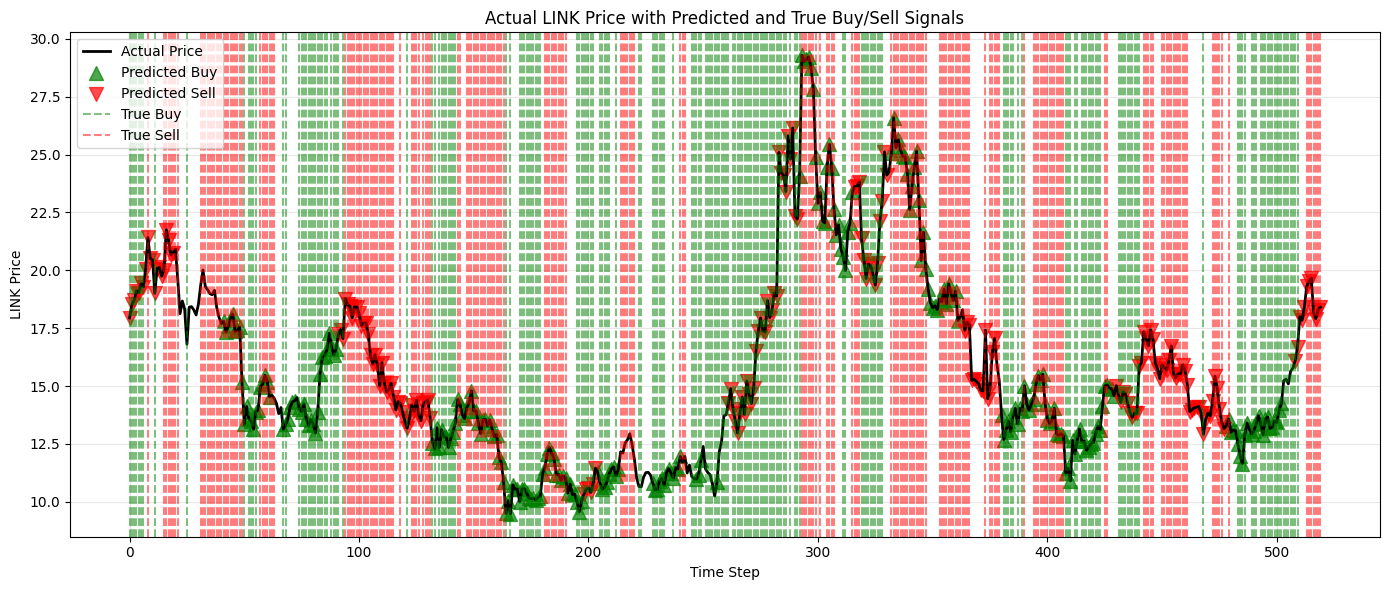

In [64]:
# Plot actual price with Predicted Buy/Sell signals and True signals as vertical lines
plt.figure(figsize=(14,6))
plt.plot(test_close, label='Actual Price', color='black', linewidth=2)

# Convert predictions and true labels from one-hot to class indices
y_pred_classes = y_pred.argmax(axis=1)
y_true_classes = y_test.argmax(axis=1)

# Predicted signal indices
pred_buy_idx = np.where(y_pred_classes == 2)[0]
pred_sell_idx = np.where(y_pred_classes == 0)[0]

# True signal indices
true_buy_idx = np.where(y_true_classes == 2)[0]
true_sell_idx = np.where(y_true_classes == 0)[0]

# Plot predicted signals as markers
plt.scatter(pred_buy_idx, test_close[pred_buy_idx], color='green', label='Predicted Buy', marker='^', s=100, alpha=0.7)
plt.scatter(pred_sell_idx, test_close[pred_sell_idx], color='red', label='Predicted Sell', marker='v', s=100, alpha=0.7)

# Plot true signals as vertical lines
for idx in true_buy_idx:
    plt.axvline(x=idx, color='green', linestyle='--', linewidth=1.5, alpha=0.5, label='True Buy' if idx == true_buy_idx[0] else "")
for idx in true_sell_idx:
    plt.axvline(x=idx, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='True Sell' if idx == true_sell_idx[0] else "")

plt.title('Actual LINK Price with Predicted and True Buy/Sell Signals')
plt.xlabel('Time Step')
plt.ylabel('LINK Price')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [52]:
# Save the best model and related data
print("Saving model and related data...")

# Create models directory if it doesn't exist
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Generate timestamp for unique filenames
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save the trained model
model_filename = f"{models_dir}/lstm_model_{timestamp}.h5"
model.save(model_filename)
print(f"Model saved as: {model_filename}")

# Save the scaler
scaler_filename = f"{models_dir}/scaler_{timestamp}.pkl"
with open(scaler_filename, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved as: {scaler_filename}")

# Save the best parameters
params_filename = f"{models_dir}/best_params_{timestamp}.pkl"
with open(params_filename, 'wb') as f:
    pickle.dump(best_params, f)
print(f"Best parameters saved as: {params_filename}")

# Save model configuration
config = {
    'lookback': lookback,
    'lookahead': lookahead,
    'features': features,
    'timestamp': timestamp,
    'best_validation_loss': trial.value
}
config_filename = f"{models_dir}/model_config_{timestamp}.pkl"
with open(config_filename, 'wb') as f:
    pickle.dump(config, f)
print(f"Model configuration saved as: {config_filename}")

Saving model and related data...
Model saved as: saved_models/lstm_model_20250811_003300.h5
Scaler saved as: saved_models/scaler_20250811_003300.pkl
Best parameters saved as: saved_models/best_params_20250811_003300.pkl
Model configuration saved as: saved_models/model_config_20250811_003300.pkl


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
# Function to load the saved model
from keras.models import load_model

# Re-import your focal loss definition
def focal_loss_fixed(y_true, y_pred, gamma=2., alpha=.25):
    import tensorflow as tf
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * tf.math.log(y_pred)
    weight = alpha * tf.pow(1 - y_pred, gamma)
    loss = weight * cross_entropy
    return tf.reduce_sum(loss, axis=1)

def load_saved_model(model_path, scaler_path, params_path, config_path):
    """
    Load a saved LSTM model and related data
    """
    print("Loading saved model...")
    
    # Load the model
    #loaded_model = load_model(model_path)
    # Load model with the custom loss
    loaded_model = load_model(model_path, custom_objects={'focal_loss_fixed': focal_loss_fixed})
    print(f"Model loaded from: {model_path}")
    
    # Load the scaler
    with open(scaler_path, 'rb') as f:
        loaded_scaler = pickle.load(f)
    print(f"Scaler loaded from: {scaler_path}")
    
    # Load the parameters
    with open(params_path, 'rb') as f:
        loaded_params = pickle.load(f)
    print(f"Parameters loaded from: {params_path}")
    
    # Load the configuration
    with open(config_path, 'rb') as f:
        loaded_config = pickle.load(f)
    print(f"Configuration loaded from: {config_path}")
    
    return loaded_model, loaded_scaler, loaded_params, loaded_config

# Function to make predictions with loaded model
def predict_with_loaded_model(model, scaler, config, new_data):
    """
    Make predictions using a loaded model
    """
    # Scale the new data
    new_data_reshaped = new_data.reshape(-1, new_data.shape[-1])
    new_data_scaled = scaler.transform(new_data_reshaped).reshape(new_data.shape)
    
    # Make predictions
    predictions = model.predict(new_data_scaled)
    
    return predictions

# Example of loading and using the saved model
print("\n=== Example: Loading and Using Saved Model ===")

# Load the saved model (you can comment this out if you want to continue with the current model)
loaded_model, loaded_scaler, loaded_params, loaded_config = load_saved_model(
    model_filename, scaler_filename, params_filename, config_filename
)


=== Example: Loading and Using Saved Model ===
Loading saved model...
Model loaded from: saved_models/lstm_model_20250806_022746.h5
Scaler loaded from: saved_models/scaler_20250806_022746.pkl
Parameters loaded from: saved_models/best_params_20250806_022746.pkl
Configuration loaded from: saved_models/model_config_20250806_022746.pkl


In [27]:
# Test the loaded model on the test set
print("Testing loaded model...")
loaded_predictions = predict_with_loaded_model(loaded_model, loaded_scaler, loaded_config, X_test)
print(f"Loaded model predictions shape: {loaded_predictions.shape}")

# Compare with original predictions
original_predictions = model.predict(X_test_scaled)
print(f"Original model predictions shape: {original_predictions.shape}")

# Check if predictions are the same (they should be)
if np.allclose(loaded_predictions, original_predictions, rtol=1e-5):
    print("✅ Loaded model predictions match original model!")
else:
    print("❌ Loaded model predictions differ from original model")

Testing loaded model...
24/24 [==============================] - 6s 11ms/step
Loaded model predictions shape: (753, 3)
24/24 [==============================] - 0s 10ms/step
Original model predictions shape: (753, 3)
✅ Loaded model predictions match original model!
